Install dependencies.

In [ ]:
%pip install -q -U -r requirements.txt
# The options `-q`, `-U`, `-r` respectively refers to 'quiet', 'upgrade', 'requirement'

In [1]:
from datasets import load_dataset  # HuggingFace dataset loading function

dataset = load_dataset("allganize/RAG-Evaluation-Dataset-KO")
print(dataset)

/Users/key-tech/Developer/_Prj./24.07--UCD-KeyNote/_repo--24UCD-RAG/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    test: Dataset({
        features: ['domain', 'question', 'target_answer', 'target_file_name', 'target_page_no', 'context_type', 'alli_gpt-4-turbo_answer', 'alli_gpt-4-turbo_ox', 'alli_gpt-4_answer', 'alli_gpt-4_ox', 'alli_claude3-opus_answer', 'alli_claude3-opus_ox', 'alli_eeve_answer', 'alli_eeve_ox', 'alli_Llama-3-Alpha-Ko-8B-Evo_answer', 'alli_Llama-3-Alpha-Ko-8B-Evo_ox', 'alli_meta-llama3_answer', 'alli_meta-llama3_ox', 'alli_claude-3.5-sonnet_answer', 'alli_claude-3.5-sonnet_ox', 'alli_gpt-4o_answer', 'alli_gpt-4o_ox', 'alli_meta-llama3_answer.1', 'alli_meta-llama3_ox.1', 'langchain_gpt-4-turbo_answer', 'langchain_gpt-4-turbo_ox', 'langchain_gpt-3.5-turbo_answer', 'langchain_gpt-3.5-turbo_ox', 'openai_assistant_gpt-4-turbo_answer', 'openai_assistant_gpt-4-turbo_ox', 'openai_assistant_gpt-4_answer', 'openai_assistant_gpt-4_ox', 'cohere_command-r_answer', 'cohere_command-r_ox', 'cohere_command-r-plus_answer', 'cohere_command-r-plus_ox', 'anything_llm_gpt-4-turbo_an

---

Before the steps below, Qdrant must be running in the background.
</br>This could be acheived by executing the following shell command.[^1]

```shell
docker run -p 6333:6333 -p 6334:6334 \
   -v $(pwd)/qdrant_storage:/qdrant/storage:z \
   qdrant/qdrant
```

[^1]: https://qdrant.tech/documentation/quick-start/#download-and-run

In [2]:
from qdrant_client import QdrantClient
client = QdrantClient("localhost", port=6333)

In [3]:
df_pandas = dataset['test'].to_pandas()
documents = df_pandas['target_answer'].to_list()
ids = list(range(1,len(documents)+1))

In [4]:
client.delete_collection(collection_name= "general_finance_service")
client.add(
    collection_name= "general_finance_service",
    documents= documents,
    ids= ids
)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [5]:
import dspy
from llama_cpp import Llama


llm = Llama(
    model_path="./_ignore/model/gemma-2-9b-it-Q4_K_M.gguf",
    n_gpu_layers=-1,
    n_ctx=0,
    verbose=False
)


llamalm = dspy.LlamaCpp(
    model="llama",
    llama_model=llm,
    model_type="chat",
    temperature=0.4
)


In [6]:
from dspy.retrieve.qdrant_rm import QdrantRM

qdrant_retriever_model = QdrantRM("general_finance_service", client, k=10)

dspy.settings.configure(lm=llamalm, rm=qdrant_retriever_model)

In [7]:
# client.set_model("intfloat/multilingual-e5-large") # not tested yet
# ※ https://qdrant.github.io/fastembed/examples/Supported_Models/#supported-text-embedding-models

In [8]:
class RAG(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()

        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.Predict("context, question -> answer")
    
    def forward(self, question):
        context = self.retrieve(question).passages
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.answer)

In [9]:
uncompiled_rag = RAG()
query = "2010년 미국에서 50세 미만에서 발생한 직장암과 결장암의 퍼센트는 어떻게 되며, 이 비율이 2030년에는 어떻게 변할 것으로 예상되는가?"
response = uncompiled_rag(query)

print(response.answer)

Context: 
[1] «주요 국가들은 지구 평균 기온 상승폭을 1.5oC 이내로 억제하기 위해 2030년까지 2010년 대비 탄소배출량을 45% 감축하고, 2050년에는 탄소배출량을 0으로 만드는 넷제로를 달성해야 한다는 목표를 가지고 있습니다.»
[2] «2010년 미국에서 발생한 결장암의 5%, 직장암의 9%가 50세 미만이었으나, 최근의 증가 추세에


![스크린샷 2024-06-12 21.01.17.png](<attachment:스크린샷 2024-06-12 21.01.17.png>)
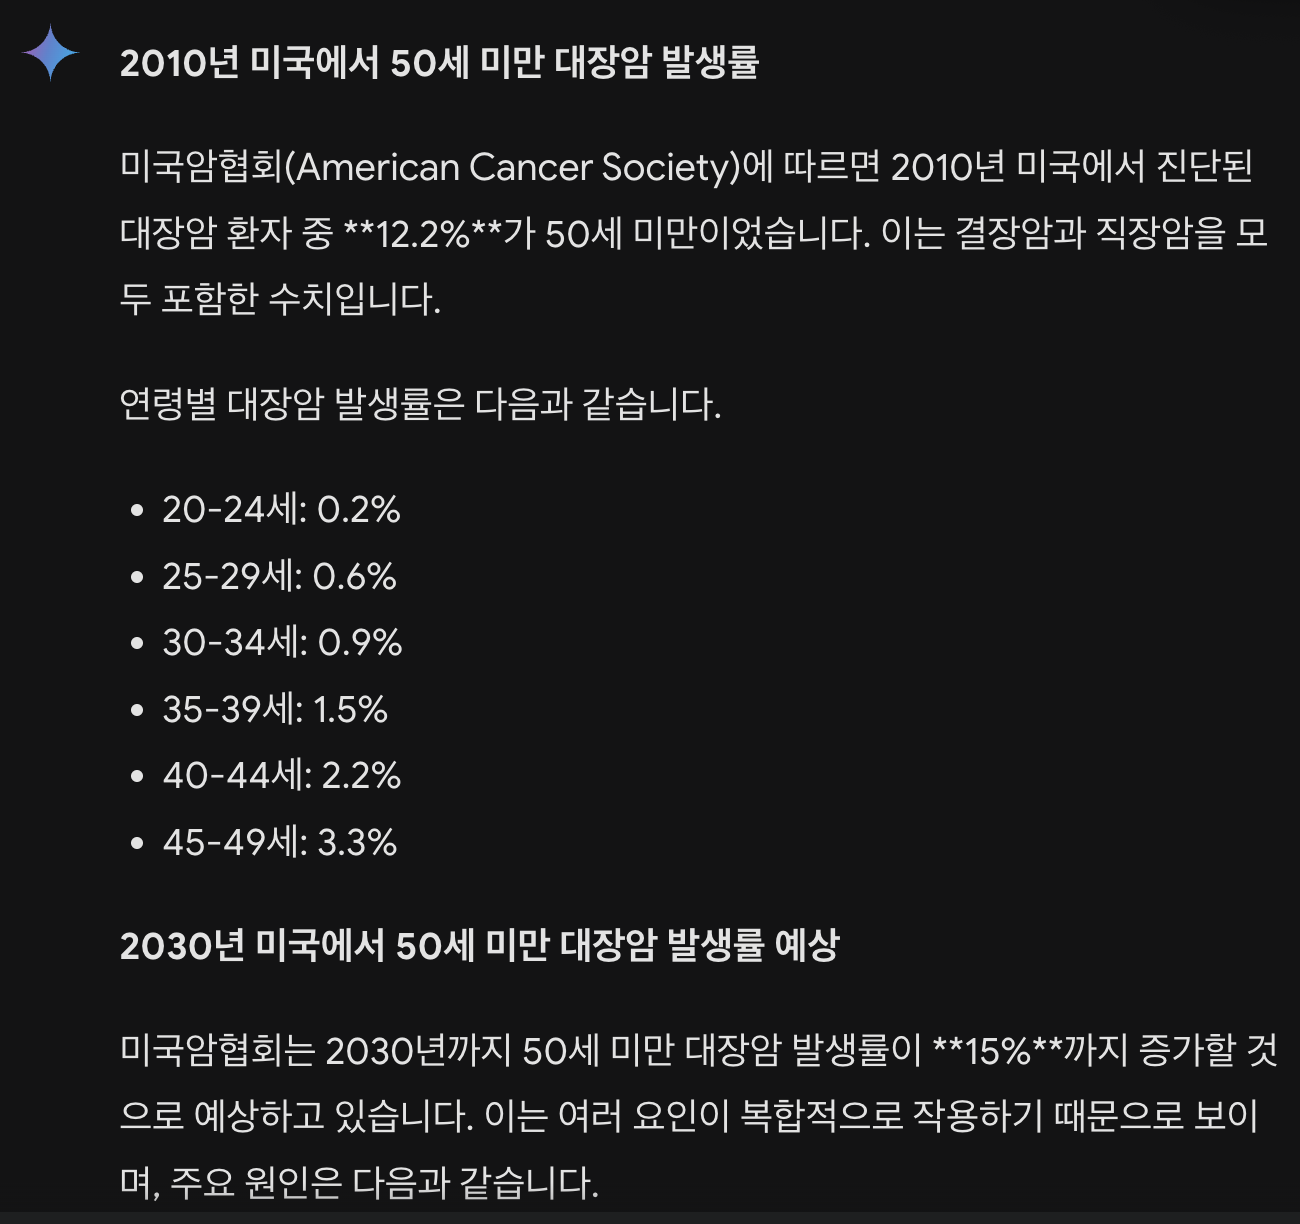
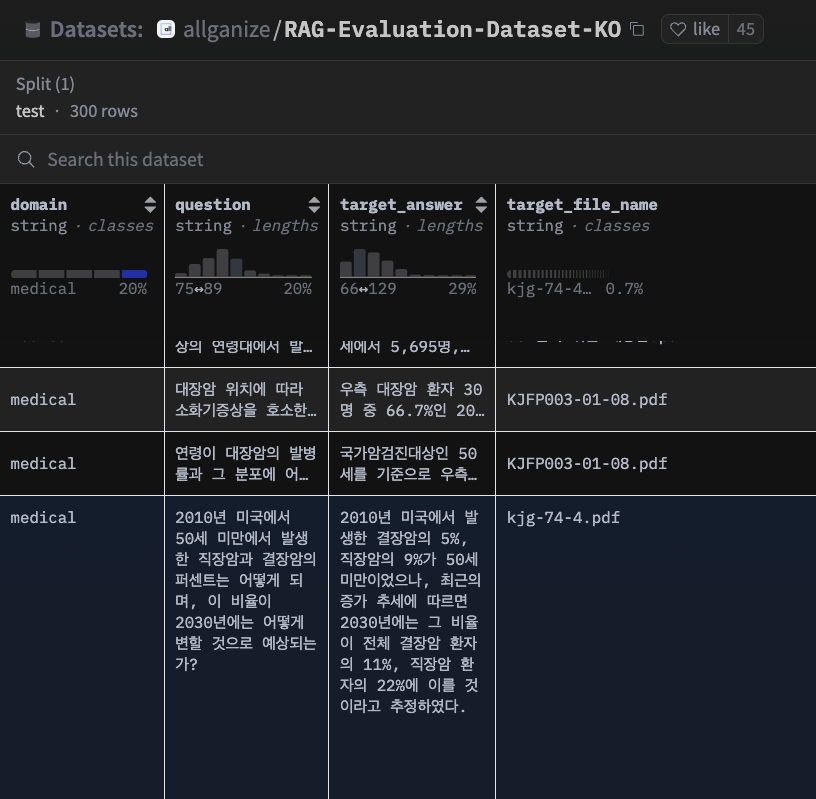